# Music Style Transfer using Convolutional Neural Network

**Pratik Mahajan**<br/>
Information Systems Department<br/>
Northeastern University<br/>
mahajan.pr@husky.neu.edu<br/>

In [1]:
import tensorflow as tf
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa

In [2]:
CONTENT_FILENAME = "input/content.mp3"
STYLE_FILENAME = "input/style.mp3"

In [29]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

Below Function divides the sound signal into its phase and magnitude. 

In [30]:
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S) #Phase of frequency
    
    S = np.log1p(np.abs(S[:,:430]))  #Magnitude of frequency
    return S, fs

In [31]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

In [32]:
print N_SAMPLES

430


In [33]:
print N_CHANNELS

1025


In [34]:
a_content

array([[1.19489335e-01, 3.17634702e-01, 2.30804652e-01, ...,
        2.25273058e-01, 4.25936788e-01, 3.14234525e-01],
       [7.84202665e-02, 2.70429045e-01, 4.10043448e-01, ...,
        1.78141594e-01, 1.94138706e-01, 3.75377178e-01],
       [6.00185171e-02, 3.39107960e-01, 5.91374993e-01, ...,
        1.62087545e-01, 1.75406352e-01, 3.93624425e-01],
       ...,
       [6.12957083e-05, 4.63598371e-05, 1.31132067e-04, ...,
        7.11130779e-05, 2.78655672e-04, 3.84868879e-04],
       [1.58850999e-05, 2.06138702e-05, 3.73205294e-05, ...,
        2.75193470e-05, 2.13146966e-04, 2.08317229e-04],
       [3.34761753e-05, 1.70080730e-05, 7.46243904e-06, ...,
        7.40359974e-05, 1.81050564e-04, 9.30548922e-05]], dtype=float32)

In [35]:
a_content.shape

(1025, 430)

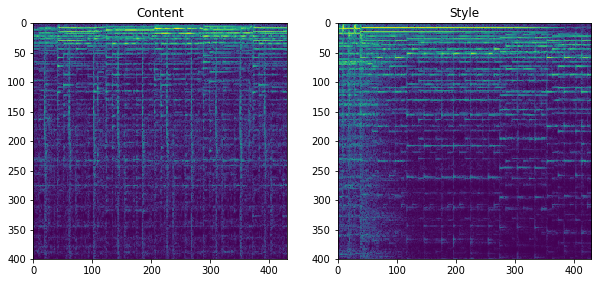

In [36]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

In [37]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    


In [38]:
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x") #inputting data to graph 

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    # convolutional neural network 
    conv = tf.nn.conv2d(
        x, #input
        kernel_tf, #filter
        strides=[1, 1, 1, 1],
        padding="VALID", # without padding 
        name="conv")
    #negative to 0- relu
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

In [40]:
net

<tf.Tensor 'Relu:0' shape=(1, 1, 420, 4096) dtype=float32>

In [41]:
a_content_tf.shape

(1, 1, 430, 1025)

In [42]:
a_content.shape

(1025, 430)

In [43]:
content_features.shape

(1, 1, 420, 4096)

In [44]:
from sys import stderr

ALPHA= 1e-2
# learning_rate= 1e-3
# iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x, #input
        kernel_tf, #filter
        strides=[1, 1, 1, 1],
        padding="VALID", # without padding 
        name="convol")
    
    
    net = tf.nn.relu(conv)

#     net = tf.nn.sigmoid(conv)
    
    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Calculating Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 100})
    
    
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
#         sess.run(tf.global_variables_initializer())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print 'Final loss:', loss.eval()
        result = x.eval()

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  Objective function value: 1058.557617
  Number of iterations: 100
  Number of functions evaluations: 111
Final loss: 1058.5576


In [45]:
net.shape

TensorShape([Dimension(1), Dimension(1), Dimension(420), Dimension(4096)])

In [46]:
width

420

In [47]:
feats

<tf.Tensor 'Reshape:0' shape=(420, 4096) dtype=float32>

In [48]:
gram

<tf.Tensor 'div:0' shape=(4096, 4096) dtype=float32>

In [49]:
opt

In [50]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'output/out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [51]:
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

output/out.wav


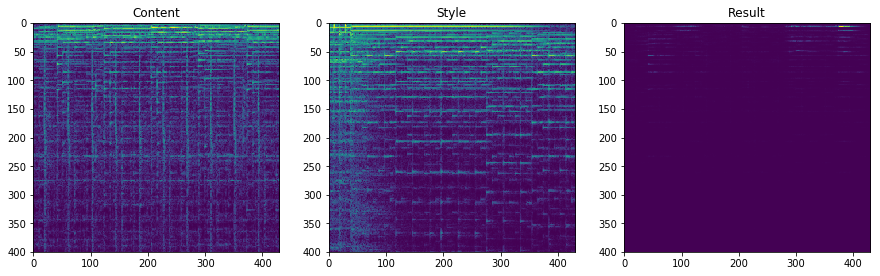

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()

## References

[1] Leon A. Gatys, Alexander S. Ecker, Matthias Bethge,"A Neural Algorithm of Artistic Style" <br/>
[2] Shuqi Dai, Zheng Zhang, Gus G. Xia, "Music Style Transfer: A Position Paper"<br/>
[3] L. Wyse, "Audio Spectrogram Representations for Processing with Convolutional Neural Networks," vol. 1, no. 1, pp. 37–41, 2017.<br/>
[4] "What’s wrong with CNNs and spectrograms for audio processing?" https://towardsdatascience.com/whats-wrong-with-spectrograms-and-cnns-for-audio-processing-311377d7ccd<br/>
[5] https://github.com/vadim-v-lebedev/audio_style_tranfer <br/>
[6] https://github.com/Lasagne/Recipes/blob/master/examples/styletransfer/Art%20Style%20Transfer.ipynb <br/>
[7] Extreme Style Machines: Using Random Neural Networks to Generate Textures https://nucl.ai/blog/extreme-style-machines/ <br/>
[8] Ivan Ustyuzhaninov, Wieland Brendel, Leon A. Gatys, Matthias Bethge, "Texture Synthesis Using Shallow Convolutional Networks with Random Filters"<br/>
[9] Kun He, Yan Wang, John Hopcroft, "A Powerful Generative Model Using Random Weights for the Deep Image Representation"<br/>
[10] Shaun Barry, Youngmoo Kim, "“Style” Transfer for Musical Audio Using Multiple Time-Frequency Representations "
[11] Dmitry Ulyanov and Vadim Lebedev, "Audio texture synthesis and style transfer"
[12] D. Griffin, jae Lim, "Signal estimation from modified short-time Fourier transform"

last updated: 08/17/2018